<a href="https://colab.research.google.com/github/nafiuopeyemi88/E_Commerce/blob/main/RF_model_farm_sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install geopandas rasterio rasterstats shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.9 MB/s 
     |████████████████████████████████| 19.3 MB 362 kB/s 
     |████████████████████████████████| 6.3 MB 26.8 MB/s 
     |████████████████████████████████| 16.7 MB 46.1 MB/s 
     |████████████████████████████████| 130 kB 72.2 MB/s 


In [ ]:
%pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install treeinterpreter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import required libraries/modules
import numpy as np
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import rasterio 
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium
from os import path as op
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti


In [ ]:
#files used in this project are stored in google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
root_dir = "/content/drive/My Drive/Colab Notebooks/Image_classification_data"

In [ ]:
#the training data is read in from the shapefile created
training_data = '/content/drive/My Drive/Colab Notebooks/Image_classification_data/Eyork_training.shp'
training_vectors = gpd.read_file(training_data)



In [ ]:
# creating a boundary box for mapping
bbox = training_vectors.total_bounds
center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

training_vectors.head(7)

,Id,Name,geometry
0,0,Urban,"MULTIPOLYGON (((674945.285 5966643.651, 674939..."
1,0,Wheat,"MULTIPOLYGON (((675330.958 5967084.441, 675329..."
2,0,Vining_Beans,"MULTIPOLYGON (((675858.904 5967297.923, 675841..."
3,0,Grass,"MULTIPOLYGON (((675207.697 5967883.093, 675202..."
4,0,Oil_seed_rape,"POLYGON ((675458.775 5967613.887, 675474.650 5..."
5,0,Oil_seed_rape,"POLYGON ((675500.051 5967648.812, 675520.688 5..."
6,0,Oil_seed_rape,"POLYGON ((675375.432 5967618.650, 675384.163 5..."


In [ ]:
#getting unique training site classes, sorted by name
classes = np.unique(training_vectors.Name)
classes

array(['Grass', 'Oil_seed_rape', 'Urban', 'Vining_Beans', 'Wheat'],
      dtype=object)

In [ ]:
class_dict = dict(zip(classes, range(len(classes))))
class_dict 

{'Grass': 0, 'Oil_seed_rape': 1, 'Urban': 2, 'Vining_Beans': 3, 'Wheat': 4}

In [ ]:
#image file
#reading in the layer_stacked image file for classification
raster_file = '/content/drive/My Drive/Colab Notebooks/Image_classification_data/sentinel.tif'
#raster file for testing the model


In [ ]:
def all_values(x):
    return x

# this larger cell reads data from a raster file for each training vector
X_raw = []
y_raw = []
with rasterio.open(raster_file, 'r') as src:
    for (label, geom) in zip(training_vectors.Name, training_vectors.geometry):
        
        # read the raster data matching the geometry bounds
        window = bounds_window(geom.bounds, src.transform)
        # store our window information
        window_affine = src.window_transform(window)
        fsrc = src.read(window=window)
        # rasterize the geometry into the larger shape and affine
        mask = rasterize(
            [(geom, 1)],
            out_shape=fsrc.shape[1:],
            transform=window_affine,
            fill=0,
            dtype='uint8',
            all_touched=True
        ).astype(bool)
        
        # for each label pixel (places where the mask is true)
        label_pixels = np.argwhere(mask)
        
        for (row, col) in label_pixels:
            # add a pixel of data to X
            data = fsrc[:,row,col]
            one_x = np.nan_to_num(data, nan=1e-3)
            X_raw.append(one_x)
            # add the label to y
            y_raw.append(class_dict[label])


In [ ]:
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

((854, 6), (854,))

In [ ]:
# Using helper function for calculating NDVI and NDWI indices

def band_index(arr, a, b):
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

ndvi = band_index(X, 3, 2)
ndwi = band_index(X, 1, 3)

X = np.concatenate([X, ndvi, ndwi], axis=1)
X.shape

(854, 8)

In [ ]:
# splitting the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# calculate class weights to allow for training on inbalanced training samples
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

{0: 0.01694915254237288,
 1: 0.007874015748031496,
 2: 0.07692307692307693,
 3: 0.009009009009009009,
 4: 0.002680965147453083}

In [ ]:
# initializing a RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    max_depth=6,
    n_jobs=-1,
    verbose=1,
    random_state=0)

In [ ]:
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


RandomForestClassifier(class_weight={0: 0.01694915254237288,
                                     1: 0.007874015748031496,
                                     2: 0.07692307692307693,
                                     3: 0.009009009009009009,
                                     4: 0.002680965147453083},
                       max_depth=6, n_estimators=200, n_jobs=-1, random_state=0,
                       verbose=1)

In [ ]:
# predicting on X_test to evaluate the model
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
#saving the model pickle file for further use
model_name = op.join(root_dir,'random_forest_.sav')
with open(model_name, 'wb') as modelfile:
    pickle.dump(clf, modelfile)

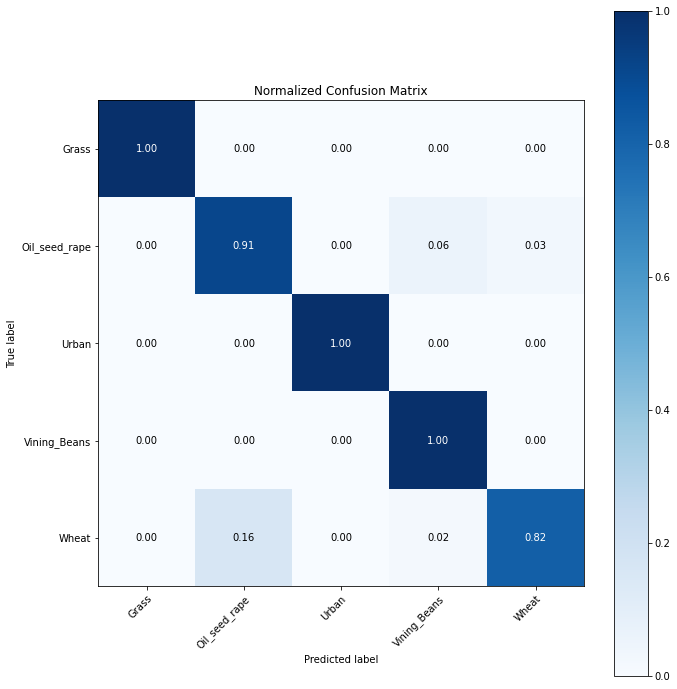

In [ ]:
# plotting the confusion matrix
%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)


ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [ ]:
# predict again with the tree interpreter to see how much each band contributes to the classification
sample = 100
prediction, bias, contributions = ti.predict(clf, X_test[:sample])
c = np.sum(contributions, axis=0)

In [ ]:
# plot the contributions
band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDWI']

gdf = gpd.GeoDataFrame(c, columns=classes, index=band_names)
gdf.style.background_gradient(cmap='viridis')

,Grass,Oil_seed_rape,Urban,Vining_Beans,Wheat
Blue,-1.182543,0.672480,-3.901252,0.456470,3.954845
Green,-0.212342,0.704144,-2.580270,-0.123010,2.211478
Red,-2.856960,1.086123,-1.764771,0.643970,2.891639
NIR,-1.855803,-0.089399,-1.613553,0.918445,2.640309
SWIR1,0.052523,-0.294542,-2.756067,0.106199,2.891887
SWIR2,-2.857315,1.473799,-1.805828,-1.854632,5.043977
NDVI,-2.889604,-0.839096,-0.282945,-0.782795,4.794439
NDWI,-0.954113,0.295894,-1.907309,0.489024,2.076504


In [ ]:
# in this case, we predict over the entire input image
# (only small portions were used for training)
new_image = raster_file

# specify the output
output_image = op.join(root_dir, "rf_classification_testnew.tif")

with rasterio.open(new_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:

        # perform prediction on each small image patch to minimize required memory
        patch_size = 500

        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write) with rasterio windows reading
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size))
                
                # read the image into the proper format
                data = src.read(window=window)
                
                # adding indices if necessary
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                img_ndvi = band_index(img_flat, 3, 2)
                img_ndwi = band_index(img_flat, 1, 3)

                img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi], axis=1)

                # remove no data values, store the indices for later use
                m = np.ma.masked_invalid(img_w_ind)
                to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])

                # skip empty inputs
                if not len(to_predict):
                    continue
                # predict
                img_preds = clf.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # makes the assumption that all bands have identical no-data value arrangements
                output = np.zeros(img_flat.shape[0])
                output[~m.mask[:, 0]] = img_preds.flatten()
                # resize to the original image dimensions
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                # write to the final files
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


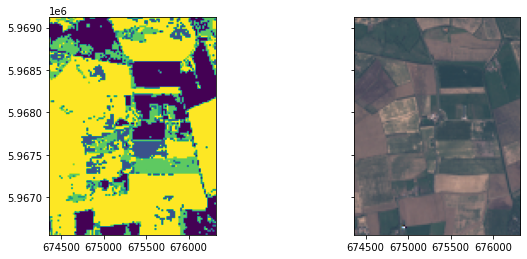

In [ ]:
### Visualize the results
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline

# Load the original image
# Load the classification

output_image = '/content/drive/My Drive/Colab Notebooks/Image_classification_data/rf_classification_testnew.tif'

def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
#  show(class_raster)
  classes = class_raster.read()

# Compare side by side
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])
  for band in range(s2.shape[0]):
    s2[band] = linear_rescale(
            s2[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2 = s2.astype(np.uint8)
  #print(s2.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(classes, transform=class_raster.transform, ax=ax1)
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2)

In [ ]:
from sklearn.metrics import confusion_matrix
percentage = clf.score(X_test, y_test)
res = confusion_matrix(y_test, preds)
print("Confusion Matrix")
print(res)
print(f"Test Set: {len(X_test)}")
print(f"Accuracy = {percentage*100} %")

Confusion Matrix
[[13  0  0  0  0]
 [ 0 31  0  2  1]
 [ 0  0  3  0  0]
 [ 0  0  0 22  0]
 [ 0 16  0  2 81]]
Test Set: 171
Accuracy = 87.71929824561403 %


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, preds)
cohen_score

0.8087350199733688